# Verification of Dynamical Simulation

**Yuning Zhang, TU Delft, 2021.10.23**

Verify the time evolution using a full scale Hamiltonian simulation, provided by `QuantumOptics.jl`. 

The function $f(t)=\langle S_x(t) \rangle$ generated by our code is compared with the simulation of `QuantumOptics.jl`. 
If the shape is the same then it's successful.

In [442]:
using QuantumOptics
using Plots
include("SpinEnsemble.jl")

ensemble_average_FID

## Free Induction Decay 

with zero transerve magnetic field (h=0)

In [2]:
b=SpinBasis(1//2)
sigma_z=sigmaz(b)
sigma_x=sigmax(b)
sigma_i=sigma_z*sigma_z

"""
contruct the Hamiltonian of the ensemble, 
Args:
    D: dipolar coupling strength 
    H_R: transerve magnetic field
"""
function ensemble_Hamiltonian(D::Vector{Float64},H_R::Float64)
    N=length(D)
    L=repeat([sigma_i],N)

    H=H_R*tensor(sigma_x/2,L...)
    for i in 1:N
        L[i]=sigma_z/2
        H+=2*D[i]*tensor(sigma_z/2,L...)
        L[i]=sigma_i
    end
    return H
end

ensemble_Hamiltonian

In [3]:
N=5
D=rand_bath_dipolar_coefs(N,3);
H=ensemble_Hamiltonian(D,0.0);
T=t_adaptive(D,1001)

### f(t) given by our code, via a product of cos terms

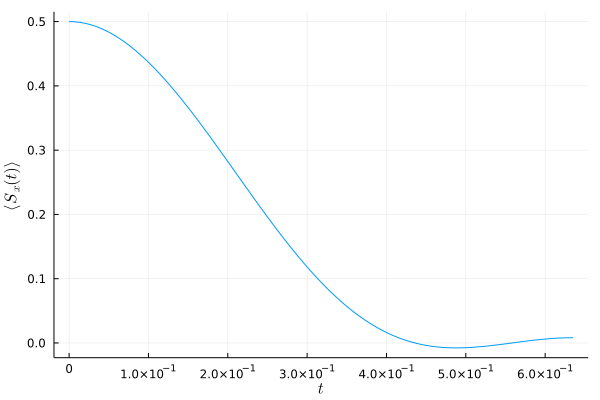

In [15]:
# plot the decay curve using the direct production
plot(T,ensemble_FID(T,D);FID_plot_options...)

### f(t) given by simulation

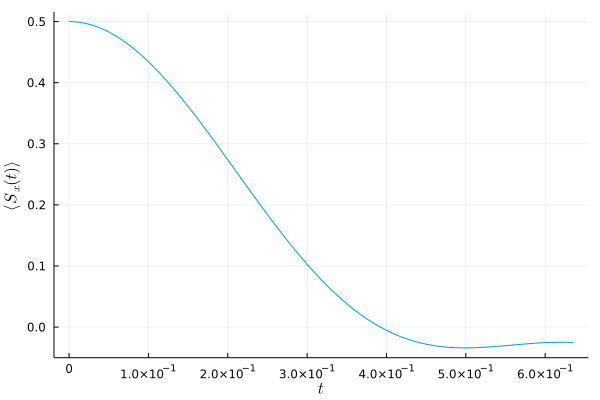

In [16]:
# plot the decay curve by simulating the time evolution of the composite system
sigma_x_0=tensor(sigma_x/2,repeat([sigma_i],N)...)
psi0=tensor(sigma_i/2+sigma_x/2,repeat([sigma_i/2],N)...)
exp_func(t, psi) = expect(sigma_x_0, psi)
tout, exp_val = timeevolution.schroedinger(2*T, psi0, H; fout=exp_func);
plot(T,real(exp_val);FID_plot_options...)

## Decay curve of the central spin under driving

with non-zero transerve magnetic field (h!=0)

In [17]:
N=5
D=rand_bath_dipolar_coefs(N,3,1.0);
H=ensemble_Hamiltonian(D,1.0);
T=0:0.01:2;

### f(t) from Monte-Carlo sampling 

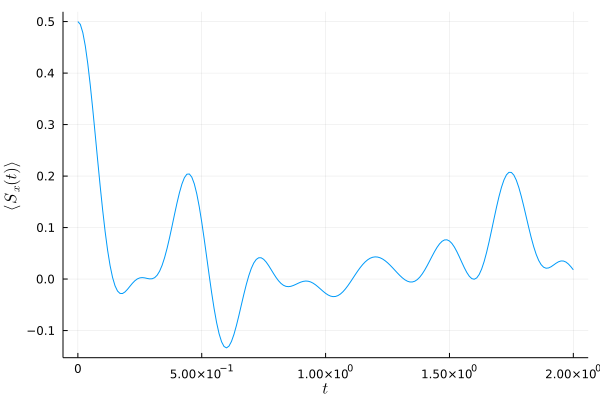

In [18]:
# plot the decay curve using the direct production
f_s=f_sampling(T,D,1.0;N=100)
plot(T,f_s;FID_plot_options...)

### f(t) from full scale simulation

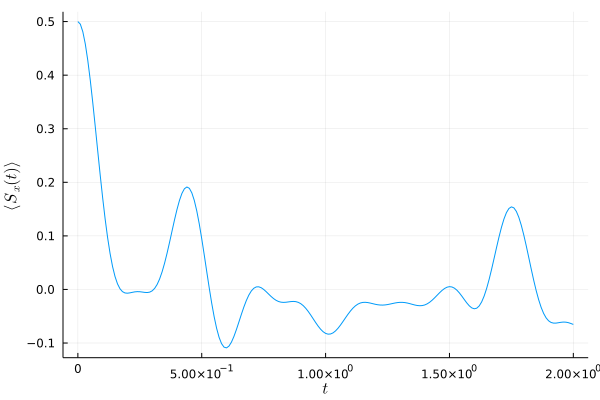

In [19]:
# plot the decay curve by simulating the time evolution of the composite system
sigma_x_0=tensor(sigma_x/2,repeat([sigma_i],N)...)
psi0=tensor(sigma_i/2+sigma_x/2,repeat([sigma_i/2],N)...)
exp_func(t, psi) = expect(sigma_x_0, psi)
tout, exp_val = timeevolution.schroedinger(2*T, psi0, H; fout=exp_func);
plot(T,real(exp_val),;FID_plot_options...)

## Check the exponential power of the decay curve

In [566]:
include("Visualization.jl")

visual_FID

## Three Dimension (non-dilute)

In [488]:
sampling_D()=bath_dipolar_coefs(rand_locs_spherical(0.1,1,N=500,projection=:false))
t=t_adaptive(sampling_D(),500,len=501,n_sigma=1);
FID_curve=mean(@showprogress [ensemble_FID(t, sampling_D()) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [489]:
cutoff=1
f_model(t,p)=exp.(-(t/p[1]).^2)/2
p0=[1.0]
fit = curve_fit(f_model, t[cutoff:end], FID_curve[cutoff:end], p0);

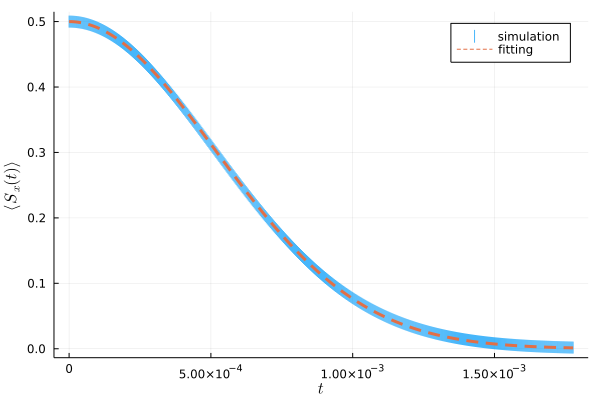

In [490]:
scatter(t,FID_curve;FID_plot_options..., labels="simulation",
markershape = :vline,
markersize = 6,
markeralpha = 0.9
)

plot!(t[cutoff:end],f_model(t[cutoff:end],fibt.param),linestyle=:dash,linewidth=3,label="fitting")

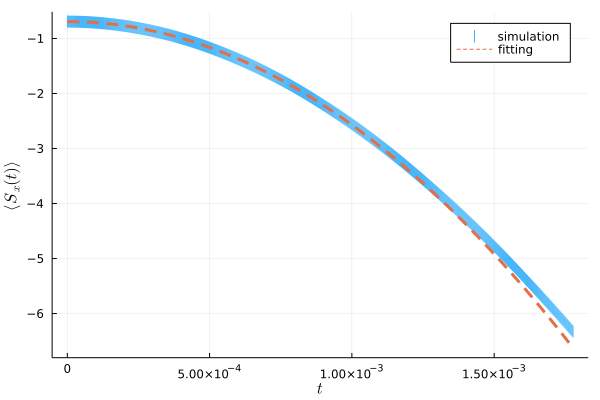

In [492]:
scatter(t,log.(FID_curve);FID_plot_options..., labels="simulation",
markershape = :vline,
markersize = 6,
markeralpha = 0.9
)

plot!(t[cutoff:end],log.(f_model(t[cutoff:end],fit.param)),linestyle=:dash,linewidth=3,label="fitting")

In [450]:
println("T_2=",abs(fit.param[1]))

T_2=0.0007222441093646523


## Three Dimension (dilute)

In [480]:
sampling_D()=bath_dipolar_coefs(rand_locs_spherical(0.1,20,N=500,projection=:false))
t=t_adaptive(sampling_D(),500,len=501,n_sigma=2);
FID_curve,error=ensemble_average_FID(t,10^3,sampling_D);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


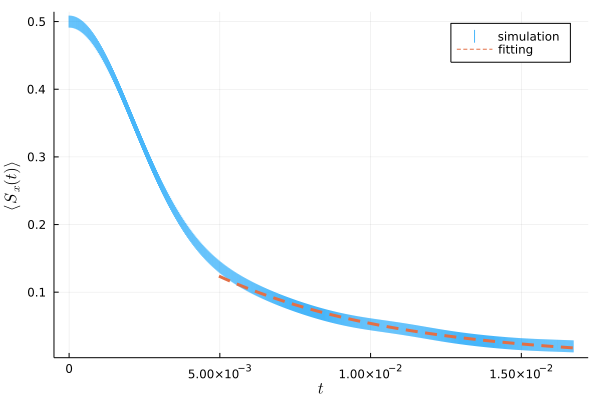

In [484]:
visual_FID(t,FID_curve,fitting=:true, cutoff=150, s=1)

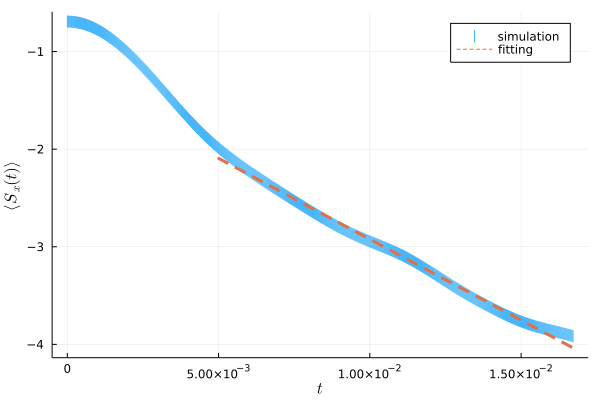

In [486]:
visual_FID(t,FID_curve,fitting=:true, cutoff=150, s=1,logscale=:true)

## Two Dimension (non-dilute)

In [580]:
sampling_D()=bath_dipolar_coefs(rand_locs_spherical(0.1,1,N=500,projection=:true))
t=t_adaptive(sampling_D(),500,len=501,n_sigma=1);
FID_curve=mean(@showprogress [ensemble_FID(t, sampling_D()) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


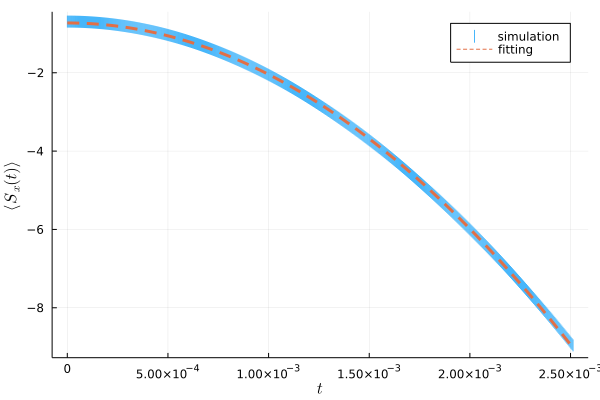

In [582]:
visual_FID(t,FID_curve,fitting=:true, cutoff=1, s=2,logscale=:true)

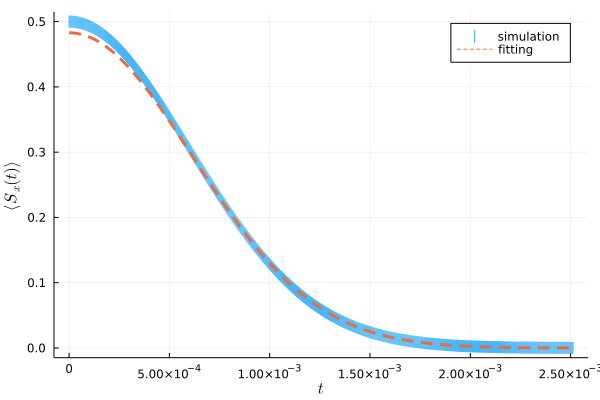

In [583]:
visual_FID(t,FID_curve,fitting=:true, cutoff=1, s=2,logscale=:false)

In [584]:
fit.param

2-element Vector{Float64}:
 0.0008691916234947411
 0.0

## Two Dimension (dilute)

In [512]:
sampling_D()=bath_dipolar_coefs(rand_locs_spherical(0.1,10,N=500,projection=:true))
t=t_adaptive(sampling_D(),500,len=501,n_sigma=1);
FID_curve=mean(@showprogress [ensemble_FID(t, sampling_D()) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


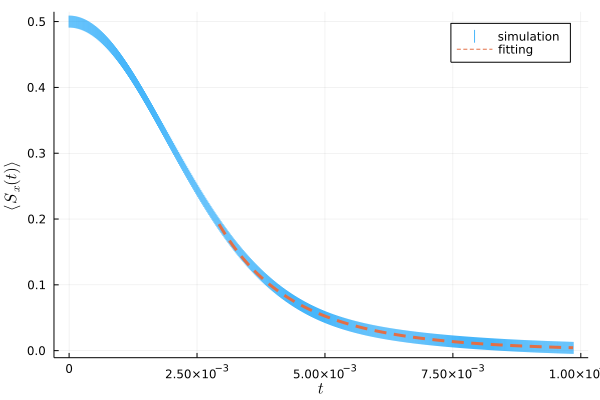

In [513]:
visual_FID(t,FID_curve,fitting=:true, cutoff=150, s=2/3,logscale=:false)

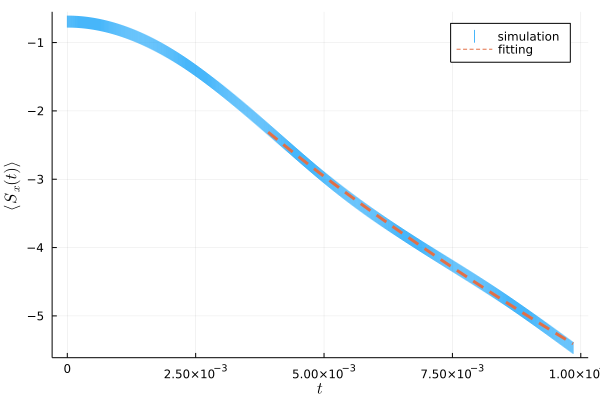

In [514]:
visual_FID(t,FID_curve,fitting=:true, cutoff=200, s=2/3,logscale=:true)

## One Dimension (Non-Dilute)

In [567]:
sampling_D()=bath_dipolar_coefs(rand_locs_cubic(0.1,1,N=400,dim=1))
t=t_adaptive(sampling_D(),500,len=501,n_sigma=1);
FID_curve=mean(@showprogress [ensemble_FID(t, sampling_D()) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


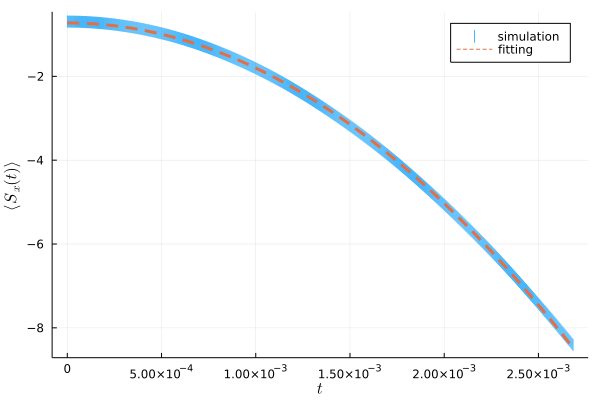

In [568]:
visual_FID(t,FID_curve,fitting=:true, cutoff=1, s=2,logscale=:true)

## One Dimension (Dilute)

In [591]:
sampling_D()=bath_dipolar_coefs(rand_locs_cubic(0.1,15,N=500,dim=1))
t=t_adaptive(sampling_D(),400,len=501,n_sigma=2);
FID_curve=mean(@showprogress [ensemble_FID(t, sampling_D()) for i in 1:10^3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


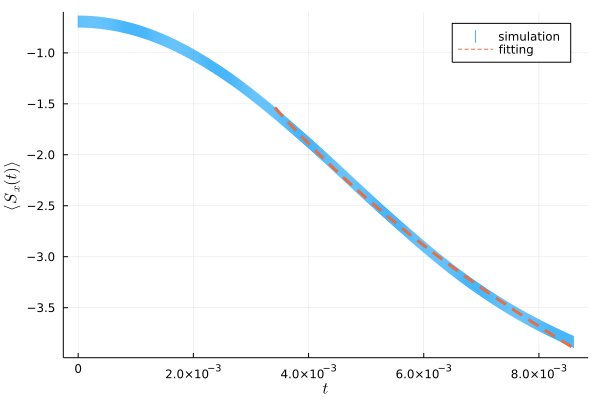

In [595]:
visual_FID(t,FID_curve,fitting=:true, cutoff=200, s=1/3,logscale=:true)